In [1]:
import train
import disc_func
import decision_tree
import similarity
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# run pip install aif360
from aif360.sklearn.datasets import fetch_adult
from sklearn.model_selection import train_test_split
from sklearn import tree
from collections import Counter
from sklearn.metrics import accuracy_score


def reload_modules():
    importlib.reload(train)
    importlib.reload(disc_func)
    importlib.reload(decision_tree)
    importlib.reload(similarity)

pip install 'aif360[LawSchoolGPA]'


In [2]:
# Fetching adult dataset
adult = fetch_adult(numeric_only=True)
adult_parameters = adult.X
adult_income = adult.y
X = adult.X.values
y = adult_income.values
# Combination of input output
Xy = np.append(X, y[:, None], axis=1)
columns = ["age", "education", "race", "sex", "capital-gain", "capital-loss", "hours-per-week"]
disc_index = 3


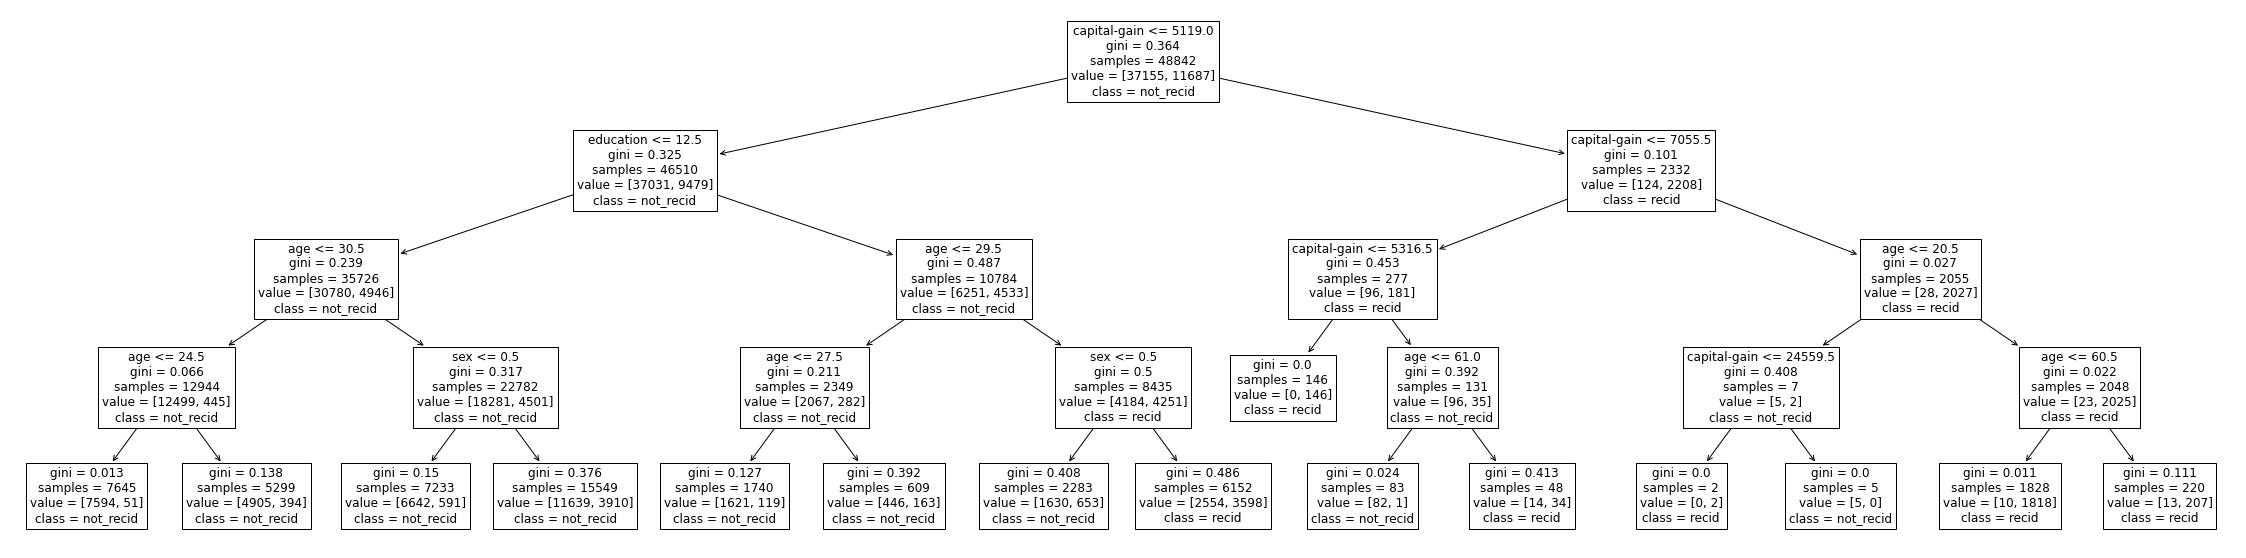

In [3]:
# Create a discriminative (but accurate) tree via sklearn
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X, y)
plt.figure(figsize=(40,10))
tree.plot_tree(clf, fontsize=12, feature_names=columns, class_names=["not_recid","recid"])
plt.show()
tree_dict = decision_tree.export_dict(clf)
for data in Xy:
    tree_dict.add_data(data)

In [11]:
def retrain_tree(tree_dict, target=None, target_method=decision_tree.get_bad_nodes_child_method, train_method=train.gain_calc, disc_func=disc_func.discrimination):
    def retrain(dec_tree, bad_node, train_method, disc_func):
        print('bad node:', bad_node.visual_json(disc_index, disc_func, attributes=columns))
        print('bad node accuracy:', bad_node.accuracy(), 'discrimination:', bad_node.discrimination(disc_index))
        good_node = bad_node.retrain_node(depth=None, train_method=train.gain_disc_priority, disc_index=disc_index)
        good_node.simplify()
        print('good node', good_node.visual_json(disc_index, disc_func, attributes=columns))
        for data in bad_node.data:
            good_node.add_data(data[:-1])
        print('good node accuracy:', good_node.accuracy(), 'discrimination:', good_node.discrimination(disc_index))
        if bad_node.unique_id == dec_tree.unique_id:
            dec_tree = good_node
        else:
            parent_node = dec_tree.get_parent(bad_node.unique_id, bad_node.get_height()+1)
            parent_node.replace_child(bad_node.unique_id, good_node)
        dec_tree.reset_data()
        for data in Xy:
            dec_tree.add_data(data)
        print('\nAccuracy', dec_tree.accuracy(), 'discrimination', dec_tree.discrimination(disc_index),'\n')
        return dec_tree

    dec_tree = tree_dict.copy()
    dec_tree.simplify()
    for data in Xy:
        dec_tree.add_data(data)
    print(dec_tree.visual_json(disc_index, disc_func, attributes=columns))
    print('BEFORE: accuracy', dec_tree.accuracy(), 'discrimination', dec_tree.discrimination(disc_index),'\n')

    bad_nodes = target_method(dec_tree, target, disc_index, disc_func=disc_func)
    if type(bad_nodes) == list:
        for bad_node in bad_nodes:
            dec_tree = retrain(dec_tree, bad_node, train_method, disc_func)
    else: 
        prev_node = dec_tree
        while(dec_tree.discrimination(disc_index, disc_func) < target and prev_node.unique_id != bad_nodes.unique_id):
            bad_nodes = target_method(dec_tree, target, disc_index, disc_func=disc_func)
            dec_tree = retrain(dec_tree, bad_nodes, train_method, disc_func)

    print('\nAFTER: accuracy', dec_tree.accuracy(), 'discrimination', dec_tree.discrimination(disc_index))
    print('predictive similarity:', similarity.predictive_similarity(tree_dict.data, dec_tree.data), 'naive discounted similarity:', similarity.naive_discounted_similarity(tree_dict, dec_tree))
    print(dec_tree.visual_json(disc_index, disc_func, attributes=columns))

In [12]:
reload_modules()

In [13]:
retrain_tree(tree_dict, target=-0.05, target_method=decision_tree.get_worst_node, train_method=train.gain_calc, disc_func=disc_func.discrimination)

{"discrimination":"-0.205", "accuracy":"0.827","capital-gain":"5119.0", "Left":{"discrimination":"-0.176", "accuracy":"0.819","education":"12.5", "Left":{"class":0.0}, "Right":{"discrimination":"-0.797", "accuracy":"0.676","age":"29.5", "Left":{"class":0.0}, "Right":{"discrimination":"-1.0", "accuracy":"0.62","sex":"0.5", "Left":{"class":0.0}, "Right":{"class":1.0}}}}, "Right":{"discrimination":"-0.091", "accuracy":"0.984","capital-gain":"7055.5", "Left":{"discrimination":"-0.457", "accuracy":"0.946","capital-gain":"5316.5", "Left":{"class":1.0}, "Right":{"discrimination":"-0.409", "accuracy":"0.885","age":"61.0", "Left":{"class":0.0}, "Right":{"class":1.0}}}, "Right":{"discrimination":"-0.007", "accuracy":"0.989","age":"20.5", "Left":{"discrimination":"0.4", "accuracy":"1.0","capital-gain":"24559.5", "Left":{"class":1.0}, "Right":{"class":0.0}}, "Right":{"class":1.0}}}}
BEFORE: accuracy 0.8265222554358953 discrimination -0.20516789939003247 

bad node: {"discrimination":"-1.0", "accur